<a href="https://colab.research.google.com/github/draglar/team2_dcs6_loan_prediction/blob/main/Copy_of_Loans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color=”green”> Importing libraries </font>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## <font color=”green”> Loading dataset </font>

In [ ]:
loans = pd.read_csv('train_dataset.csv')
# test = pd.read_csv('test_dataset.csv')

## <font color=”green”>Exploring our Dataset  </font>

In [ ]:
loans.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1


In [ ]:
loans.tail()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
164304,10164305,"20,725",10+ years,Rent,NaN,VERIFIED - income source,credit_card,13.56,0,NaN,13,16,Male,2
164305,10164306,"6,000",8 years,Own,NaN,VERIFIED - income source,small_business,9.12,0,36.0,13,30,Male,2
164306,10164307,"20,250",10+ years,Mortgage,NaN,VERIFIED - income,credit_card,18.17,1,NaN,17,30,Male,1
164307,10164308,"10,000",4 years,Rent,NaN,not verified,major_purchase,18.75,1,48.0,16,62,Female,3
164308,10164309,"9,250",10+ years,Rent,NaN,VERIFIED - income,credit_card,19.44,1,NaN,5,9,Female,2


In [ ]:
loans.shape

(164309, 14)

In [ ]:
loans.duplicated().sum()

0

> no duplicate values

In [ ]:
loans.isna().sum()

Loan_ID                        0
Loan_Amount_Requested          0
Length_Employed             7371
Home_Owner                 25349
Annual_Income              25102
Income_Verified                0
Purpose_Of_Loan                0
Debt_To_Income                 0
Inquiries_Last_6Mo             0
Months_Since_Deliquency    88379
Number_Open_Accounts           0
Total_Accounts                 0
Gender                         0
Interest_Rate                  0
dtype: int64

> There is a lot of null values in the dataset but cannot be dropped.

* Length employed <- Some borrowers may have not been previously employed, thats why there are null values
* Home owner <- Others can be living with family and friends.
* Annual Income <- Some borrowers may have not been previously employed or some may not have a ligitimate source of income or 😅 they are politicians ... etc
* Months since deliquency <-  In a financial sense, delinquency occurs as soon as a borrower misses a payment on a loan. In contrast, default occurs when a borrower fails to repay the loan as specified in the original contract

In [ ]:
loans.dtypes

Loan_ID                      int64
Loan_Amount_Requested       object
Length_Employed             object
Home_Owner                  object
Annual_Income              float64
Income_Verified             object
Purpose_Of_Loan             object
Debt_To_Income             float64
Inquiries_Last_6Mo           int64
Months_Since_Deliquency    float64
Number_Open_Accounts         int64
Total_Accounts               int64
Gender                      object
Interest_Rate                int64
dtype: object

> Our datatypes is comprised of both intergers and strings

#### <font color=”green”>Cleaning our Dataset  </font>

**Loan amount requested**

In [ ]:
loans['Loan_Amount_Requested'] = loans['Loan_Amount_Requested'].str.replace(',', '')
loans['Loan_Amount_Requested'] = loans['Loan_Amount_Requested'].astype('int')

> Loan_Amount_Requested had commas and had to be replaced

**Lenght employed**

In [ ]:
le = loans['Length_Employed']

In [ ]:
le.unique()

array(['< 1 year', '4 years', '7 years', '8 years', '2 years',
       '10+ years', '1 year', nan, '6 years', '9 years', '3 years',
       '5 years'], dtype=object)

In [ ]:
le[le=='< 1 year'] = '0 years'
le.fillna('0 years', inplace=True)

> We combined those who did not give their time employed and those who had 0 to 1 year of employment time

In [ ]:
lef = le.str.replace('years','').str.replace('year','').str.replace('<','').str.replace('+','').str.replace(' ','')

> We then removed the strings in the column leaving only the integers

In [ ]:
loans['Length_Employed']=lef.astype('int')

**Home owner**

In [ ]:
own = loans['Home_Owner']
own.value_counts()

Mortgage    70345
Rent        56031
Own         12525
Other          49
None           10
Name: Home_Owner, dtype: int64

In [ ]:
loans['Home_Owner']=own.fillna('Other')

**Annual_Income**

In [ ]:
loans['Annual_Income'].mean()

73331.15943386468

In [ ]:
import tqdm
def fix(dfr):
  na=dfr['Annual_Income'][dfr['Annual_Income'].isna()==True].index
  # df=pd.concat([train,test])
  for ind in tqdm.tqdm(na):
    # ind=dfr['Age'].index
    purpose     =dfr['Purpose_Of_Loan'].iloc[ind]
    gender      =dfr['Gender'].iloc[ind]
    debt_income =dfr['Debt_To_Income'].iloc[ind]
    mn=(dfr['Annual_Income'][(dfr['Purpose_Of_Loan']==purpose) & 
                             (dfr['Gender']==gender) &
                             ((dfr['Debt_To_Income'] <= (debt_income+1))& 
                              (dfr['Debt_To_Income'] >= (debt_income-1))
                              )]).mean()
    # print(mn)
    dfr['Annual_Income'].iloc[ind]= mn
    pass
fix(loans)



100%|██████████| 10215/10215 [04:36<00:00, 36.98it/s]


> We imputed the null values with customers with the average income from 

1.   List item
2.   List item

customers with a similar purpose of loan and within -1,+1 of the customers debt to income.

**Deliquency**

In [ ]:
loans['Months_Since_Deliquency'].isna().sum()

88379

In [ ]:
# Creating the classifications of the customers from 
def status(x):
  if x<=3.0:
    return 'Normal'
  elif ((x>3.0) & (x<=12.0)):
    return 'Medium risk'
  elif x>12.0:
    return 'High risk'
  else:
    return 'Low risk'

In [ ]:
loans['deliquency_level']=loans.apply(lambda x: status(x['Months_Since_Deliquency']),axis=1)

In [ ]:
loans.drop('Months_Since_Deliquency',axis=1,inplace=True)
loans['deliquency_level'].value_counts()

Low risk       88379
High risk      61548
Medium risk    12210
Normal          2172
Name: deliquency_level, dtype: int64

In [ ]:
loans.dropna(inplace=True)

In [ ]:
loans.isna().sum()

Loan_ID                  0
Loan_Amount_Requested    0
Length_Employed          0
Home_Owner               0
Annual_Income            0
Income_Verified          0
Purpose_Of_Loan          0
Debt_To_Income           0
Inquiries_Last_6Mo       0
Number_Open_Accounts     0
Total_Accounts           0
Gender                   0
Interest_Rate            0
deliquency_level         0
dtype: int64

#### Checking for Outliers

In [ ]:
sns.set(rc={'figure.figsize':(18,6)},style="white")

In [ ]:
sns.boxplot(x=loans['Loan_Amount_Requested'])
sns.despine()

TypeError: ignored

In [ ]:
sns.boxplot(x=loans['Annual_Income'])
sns.despine()

In [ ]:
sns.boxplot(x=loans['Number_Open_Accounts'])
sns.despine()

In [ ]:
sns.boxplot(x=loans['Total_Accounts'])
sns.despine()

> In our interger columns we have outliers in all columns apart from loan amount requested

### <font color=”green”>Exploratory Analysis </font>

##### <font color="yellow">Univariate Analysis  </font>

In [ ]:
loans.head()

In [ ]:
# Frequency distribution table for purpose of loan attribute
loans['Purpose_Of_Loan'].value_counts()

> From the value counts the loans were purposely for debt consolidation.

In [ ]:
sns.countplot(x='Length_Employed',data=loans,palette='mako')
sns.despine()

* 10+ years were the highest to request for a loan

In [ ]:
# Plotting bar chart to show home ownership
sns.countplot(x='Home_Owner',data=loans,palette='mako')
sns.despine()

* The Mortgage home owners are the highest and owned home_owners lowest

In [ ]:
# Plotting bar chart to show income verified 
sns.countplot(x='Income_Verified',data=loans,palette='mako')
sns.despine()

 On verified income individuals the ones who have Verified income have the highest count and not verified lowest count.

In [ ]:
# Plotting bar chart to show purpose of loan 
sns.countplot(y='Purpose_Of_Loan',data=loans,palette='mako')
sns.despine()

Debt_consolidatiion had the highest count refering that loans taken were purposely for debt consolidation.

In [ ]:
# Plotting bar chart to show inquiries in last 6 months. 
sns.countplot(x='Inquiries_Last_6Mo',data=loans,palette='mako')
sns.despine()

Most of the enquiries are done during the initial months, decreasing towards the sixth month.

In [ ]:
sns.histplot(x='deliquency_level',data=loans,palette='mako')
sns.despine()

> **description deliquency**<- In a financial sense, delinquency occurs as soon as a borrower misses a payment on a loan. In contrast, default occurs when a borrower fails to repay the loan as specified in the original contractMost are low risk clients are highest and normal client who do not default are lowest

In [ ]:
sns.histplot(x='Number_Open_Accounts',data=loans,palette='mako')
sns.despine()

> Most clients have more than one accounts opened as we can see above its right-skewed.With most having more than 10.

In [ ]:
#Gender Distribution
Gender = loans['Gender'].value_counts()
labels = loans.Gender.unique()
explode = (0.1, 0) 
plt.pie(Gender, labels = labels, explode = explode,autopct = '%1.1f%%', shadow = True, startangle = 140)
plt.axis('equal')
plt.title('Pie Chart of Gender')
plt.show()

> Males have the highest percentage in loan applications with a 71 percent higher than females with percentage of 29 percent.

In [ ]:
# Plotting histogram for Total Accounts 
sns.histplot(loans['Total_Accounts'])
sns.despine()

In [ ]:
# Plotting bar chart to show Loan amount requested
sns.histplot(x='Loan_Amount_Requested',data=loans,palette='mako',bins=30)
sns.despine()

The most loan Amount value requested is 10000

##### <font color="yellow">Measures of central Tendecy  </font>

In [ ]:
# mean, mode and median Annual income

print('Mean Annual income is ' + str(loans.Annual_Income.mean()))
print('Median Annual income is ' + str(loans.Annual_Income.median()))
print('Mode Annual income is ' + str(loans.Annual_Income.mode()))

In [ ]:
# mean, mode and median Total accounts

print('Mean  Total accounts is ' + str(loans.Total_Accounts.mean()))
print('Median Total accounts is ' + str(loans.Total_Accounts.median()))
print('Mode  Total accounts is ' + str(loans.Total_Accounts.mode()))

In [ ]:
#checking for measures of central tendency of relevant columns
loans_ = loans[['Loan_Amount_Requested','Annual_Income','Inquiries_Last_6Mo','Number_Open_Accounts', 'Total_Accounts']]
loans_.describe()

### <font color=”green”>Bivariate Analysis</font>>
<font color="yellow">Comparison Graphs </font>

 **Ploting the bivariate summaries and recording observations**

In [ ]:
sns.countplot(data=loans,x='Length_Employed',hue='Interest_Rate',palette='mako')
sns.despine()

The clients who have been employed for 10 years or longer were observed to have the medium to highest interest rate.
Also the clients employed for less than one year also had high interest rate.

In [ ]:
sns.countplot(x='Income_Verified',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

> * Clients without vefified sources of income dont have a very high interest rate 
> * Clients with verified sources of high have high interest rates 
> * clients with verified income source dont have a high interest rates

In [ ]:
sns.countplot(x='Gender',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

> * For all interes high,low,and medium male clients have the highest interest rates

In [ ]:
sns.countplot(x='deliquency_level',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

> * low risk clients have the highest interest rate

In [ ]:
sns.countplot(x='Home_Owner',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

Clients with Mortage Loans have the highest interest rate followed by those who pay rent

In [ ]:
sns.countplot(y='Purpose_Of_Loan',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

Most loans were given for debt consolidation and were seen to have the highest interest rate

In [ ]:
sns.countplot(x='Inquiries_Last_6Mo',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

In [ ]:
sns.scatterplot(x='Interest_Rate',y='Total_Accounts',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

No relationship was observed between the total number of accounts and the interest rate.

In [ ]:
sns.scatterplot(x='Interest_Rate',y='Annual_Income',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

> * there is no relationship between the loan interest rate and annual income

In [ ]:
sns.scatterplot(x='Interest_Rate',y='Number_Open_Accounts',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

There is no relationship observed between the number of accounts open and the interest rate.

In [ ]:
# Ploting the bivariate summaries and recording observations
#
sns.pairplot(loans)
plt.show()

In [ ]:
# Plotting the Pearson correlation coefficient among variables
plt.figure(figsize=(20, 20))
sns.heatmap(loans.corr(),annot=True)
plt.show()

> * The columns total_accounts and number of open accounts are highly correalted with a coefficient of 0.68.

> * Interest Rate is highly correlated with 6 month Inquiries with a coefficient of 0.19

### <font color=”green”>Multivariate Analysis</font>
<background color='#fa005c--- that greenish cyan'>

In [ ]:
sns.barplot(data=loans,x='Length_Employed',y='Loan_Amount_Requested',hue='Interest_Rate',palette='mako')
sns.despine()

<font color='#00e6de'>Across the time customers are employed , interest rate 3 has the highest is characterised with high ammounts of loan requested, The average amount borrowed increases with time although its just a slight increase </font>
<font color='#fa005c'>
* interest rate 3 could be a high interest rate so that the bank can recover some of its money from those who pay and not get so much loss when customers default.
* However Since banks reward their long time members or offer incentives to new members the bank here could have most of its members at a lower interest rate 3 hence why its prominent irregardless of the time employed.</font>

<font color='#00e6de'>On 10+ years the least prominent category is interest rate 1 , based on the earlier assumption this could be the high end of the interest rates , since the bank would reward older members with lower interest rates (3) </font>

In [ ]:
sns.barplot(data=loans,x='Income_Verified',y='Loan_Amount_Requested',hue='Interest_Rate',palette='mako')
sns.despine()


><font color='#fa005c'> This further confirms the hypothesis that interest rate 1 is the highest interest rate in the dataset, since normally banks would give a high interest rate to customers whose income is not verrified to discourage them from seeking the loan and give lower interest rates to customers who have verrified incomes. </font>

><font color='#fa005c'> Those who also have no verrified income tend to seek low amounts of loans, while those with verrified incomes seek high ammounts of loans </font>

<font color='#00e6de'>This is depicted in the above plot for users whose income is verified, interest rate 3 is the highest among them.

In [ ]:
sns.barplot(data=loans,x='Gender',y='Loan_Amount_Requested',hue='Interest_Rate',palette='mako')
sns.despine()

><font color='#00e6de'> Gender does not have much of an impact on the interest rate or ammount borrowed since the patern from both genders does not change.

In [ ]:
sns.barplot(data=loans,x='deliquency_level',y='Loan_Amount_Requested',hue='Interest_Rate',palette='mako')
sns.despine()

<font color='#00e6de'>Deliquency level has an effect in the pattern of the interest rates, although there is not much difference in the average ammounts borrowed across the different deliquency levels.</font>
* <font color='#fa005c'>For those with a low risk and a normal deliquency, interest rate 3 is the most prominent while interest rate 1 is the lowest, this could be the normal interest rate handed out to everyone, however this could be the lowest interest rate and since banks consider more than one factor when awarding the interest rate the high numbers with interst rate 1 could have not fulfiled some other conditions to get awarded a lower interest rate

In [ ]:
sns.barplot(data=loans,x='Home_Owner',y='Loan_Amount_Requested',hue='Interest_Rate',palette='mako')
sns.despine()

<font color='#00e6de'> As expected those who have no houses borrow the least ammounts however they all exhibit the same pattern where the interest rate with the most customers is 3 while interest rate 1 has the least customers

In [ ]:
sns.barplot(data=loans,x='Inquiries_Last_6Mo',y='Loan_Amount_Requested',hue='Interest_Rate',palette='mako')
sns.despine()

<font color='#00e6de'> The average amount borrowed remains fairly the same for the first 5 months.

In [ ]:
sns.set(rc={'figure.figsize':(18,15)},style="white")
sns.barplot(data=loans,y='Purpose_Of_Loan',x='Loan_Amount_Requested',hue='Interest_Rate',palette='mako')
sns.despine()

<font color='#00e6de'>For most loans borrowed interest rate 3 is dominant while interest rate 1 is the least, however this changes when its a loan for vacation,medical reasons or education.
* <font color='#fa005c'> This could be because the customers probably have a decently high chance to default as is the case with alot of education loanees(<font color='#00e6de'> Helbs defaulters</font>) </font>
* <font color='#fa005c'>In medicine this could be because of an emergency and the plan to pay could not have been established before coming to get the loan, and therefore incase the loanees are start paying up the bank could have recovered a good portion if the loanee ends up defaulting.

<font color='#00e6de'> How to get the dataset for the modeling?
<font color='#fa005c'>
* Reduction using lda ?
* Reduction using feature selection ?
* Label encoding ?
* Getting dummies ?
* ..........................
</font>
</font>

#### <font color="yellow">3-D comparison plots </font>

In [ ]:
le = LabelEncoder()
loans2['Income_Verified'] = le.fit_transform(loans2['Income_Verified'])

loans2.head()

### <font color=”green”>Feature Engineering</font>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
loans

* <font color='#00e6de'>Label encoding the string columns</font>

In [ ]:
from sklearn.preprocessing import LabelEncoder
loans['Interest_Rate'] = loans['Interest_Rate'].astype('category')
for_model_lab_ = loans.drop('Loan_ID',axis=1)
le = LabelEncoder()
for name in ('Home_Owner','Gender','Income_Verified','Purpose_Of_Loan','deliquency_level','Gender'):
  labeled = le.fit_transform(loans[name])
  for_model_lab_[name] = labeled
  for_model_lab_[name]=for_model_lab_[name].astype('category')
  print(loans[name].value_counts())
  print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
  print(for_model_lab_[name].value_counts())
  print('********************************************************')

In [ ]:
x=for_model_lab.drop(['Interest_Rate',],axis=1)
y=for_model_lab['Interest_Rate']
x_train,x_test,y_train,y_test=train_test_split(x,y)

**Checking for Multicollinearity**

In [ ]:
correlations = for_model_lab.corr()
correlations

**VIF Scores**

In [ ]:
# Use calculated correlations to compute the VIF score for each variable
pd.DataFrame(np.linalg.inv(correlations.values), index = correlations.index, columns=correlations.columns)

The VIF score is found along the diagonal from top left to bottom right. Since all the VIF scores are below 5, we can say that there is no multicollinearity thus no alarming correlation between the independent variables.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
x_train = lda.fit_transform(x_train, y_train)
x_test = lda.transform(x_test)

In [ ]:
x_train.shape

<font color='#00e6de'>
Lda ended up with a dataset with just 2 attributes, well it cant be helped. Therefore well be checking out feature importances using decision trees and see if there is a trend.
</font>

In [ ]:
decision_classifier = DecisionTreeClassifier(max_depth=10)
random_forest_classifier = RandomForestClassifier( max_depth=10)
gbm_classifier = GradientBoostingClassifier( max_depth=10)

decision_classifier.fit(x, y)
random_forest_classifier.fit(x, y)
gbm_classifier.fit(x, y)

In [ ]:
pd.DataFrame({'importance' : decision_classifier.feature_importances_}, index=x.columns).sort_values(by='importance').plot(kind='barh')

In [ ]:
pd.DataFrame({'importance' : random_forest_classifier.feature_importances_}, index=x.columns).sort_values(by='importance').plot(kind='barh')

In [ ]:
pd.DataFrame({'importance' : gbm_classifier.feature_importances_}, index=x.columns).sort_values(by='importance').plot(kind='barh')

> <font color='#00e6de'></font>
<font color='#fa005c'></font>
<font color='#00e6de'>
From all the feature importances: <font color='#fa005c'> Number_Open_Accounts ,Home_Owner ,Length_Employed and Gender </font> are the least important with less than 5% importance in the entire dataset they explain <font color='#fa005c'> 4.7543, 8.2875, 6.5168 </font> respectively
</font>


### <font color='#00e6de'>Models 1</font>

In [ ]:
loan_model = loans[['Loan_Amount_Requested','Debt_To_Income','Annual_Income','Income_Verified','Inquiries_Last_6Mo','Purpose_Of_Loan','Total_Accounts','deliquency_level','Interest_Rate']]
loan_model.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder
loan_model['Interest_Rate'] = loan_model['Interest_Rate'].astype('category')
le = LabelEncoder()
for name in ('Income_Verified','Purpose_Of_Loan','deliquency_level'):
  labeled = le.fit_transform(loan_model[name])
  loan_model[name] = labeled
  #label encoding above ^
  loan_model[name] = loan_model[name].astype('category')
  # Changing to categorical
  print(loans[name].value_counts())
  print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
  print(loan_model[name].value_counts())
  print('********************************************************')

In [ ]:
x=loan_model.drop(['Interest_Rate',],axis=1)
y=loan_model['Interest_Rate']
x_train,x_test,y_train,y_test=train_test_split(x,y)

In [ ]:
#  Creating default models
decision_classifier = DecisionTreeClassifier()
random_forest_classifier = RandomForestClassifier()
gbm_classifier = GradientBoostingClassifier()
knn_classifier = KNeighborsClassifier()

# training our models
decision_classifier.fit(x_train, y_train)
random_forest_classifier.fit(x_train, y_train)
gbm_classifier.fit(x_train, y_train)

# making predictions using the models
decision_y_prediction = decision_classifier.predict(x_test) 
random_forest_y_pred = random_forest_classifier.predict(x_test)
gbm_y_pred = gbm_classifier.predict(x_test)

# evaluating the models
print('Decision Tree')
print(metrics.accuracy_score(decision_y_prediction, y_test))
print(metrics.confusion_matrix(decision_y_prediction, y_test))
print(metrics.classification_report(decision_y_prediction, y_test))


print('Random Forest')
print(metrics.accuracy_score(random_forest_y_pred, y_test))
print(metrics.confusion_matrix(random_forest_y_pred, y_test))
print(metrics.classification_report(random_forest_y_pred, y_test))

print('Gradient Boosting')
print(metrics.accuracy_score(gbm_y_pred, y_test))
print(metrics.confusion_matrix(gbm_y_pred, y_test))
print(metrics.classification_report(gbm_y_pred, y_test))


###<font color=”green”>Hyparameter Tuning</font>

### Decision Tree classifier

In [ ]:
tree = DecisionTreeClassifier()
# Train it on our training set.
tree = tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.31      0.30      0.31      8624
           2       0.45      0.45      0.45     17567
           3       0.47      0.47      0.47     14885

    accuracy                           0.43     41076
   macro avg       0.41      0.41      0.41     41076
weighted avg       0.43      0.43      0.43     41076



In [ ]:
np.bincount(y_train)

array([    0, 25305, 52964, 44959])

> While decision trees work with both numerical and categorical dependent variables, When dealing with categorical data with multiple levels, the model is biased in favor of the attributes with the most levels.

> My aproach to overcoming this was resampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

ros = RandomOverSampler()
rus = RandomUnderSampler()

x_train_over, y_train_over = ros.fit_sample(x_train, y_train)
x_train_under, y_train_under = rus.fit_sample(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing i

In [ ]:
np.bincount(y_train_under)

array([    0, 25336, 25336, 25336])

In [ ]:
tree = DecisionTreeClassifier()
# Train it on our training set.
tree = tree.fit(x_train_over, y_train_over)
y_pred = tree.predict(x_test)
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.33      0.32      0.32      8672
           2       0.46      0.46      0.46     17611
           3       0.47      0.47      0.47     14793

    accuracy                           0.43     41076
   macro avg       0.42      0.42      0.42     41076
weighted avg       0.43      0.43      0.43     41076



> oversampling did improve its performance albeit only by a bit. I tried out undersampling to see if the performance would improve

In [ ]:
tree = DecisionTreeClassifier()
# Train it on our training set.
tree = tree.fit(x_train_under, y_train_under)
y_pred = tree.predict(x_test)
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.46      0.30      0.36     12975
           2       0.36      0.45      0.40     13984
           3       0.45      0.48      0.46     14117

    accuracy                           0.41     41076
   macro avg       0.42      0.41      0.41     41076
weighted avg       0.42      0.41      0.41     41076



> Undersampling worked against this dataset, since the moment we undersampled ,alot of information from interest rate 2 and 3 was lost.
* Thus thier precisions reduced while the precision for interest rate 1 increased by a large margin, since it had all the information still intact

Thus the oversampled performed best among the three and that data is what will be fine tuned 

>Finding the best parameters (criterion, maximum depth and minimum samples split)for the decision tree 

* criterion: The function to measure the quality of a split. gini for impurities and entropy fot the information gained

>The gini impurity measures the frequency at which any element of the dataset will be mislabelled when it is randomly labeled.

> Entropy is a measure of information that indicates the disorder of the features with the target. 

* maximum depth: Is a measure of how deep the decision tree goes, having a reaaly deep tree could lead to overfitting while a shallow tree could lead to underfitting hence its a good idea to get a balance in the tree.
* min_samples_split: The minimum number of samples required to split an internal node.


I did not tune the min_samples_leaf since they are guaranteed to be there.

In [ ]:
# Avoid running this if you dont need to 8+ hours so yeah try no to
max=np.arange(1,10)
criterion =["gini", "entropy"]
min_samples_split = np.arange(2,5)

grid = GridSearchCV(estimator=DecisionTreeClassifier(),param_grid={'criterion':criterion,'min_samples_split':min_samples_split ,'max_depth':max},cv=5,verbose=1)
grid.fit(x,y)
print('The best parameters ',grid.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.6min finished


The best parameters  {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 2}


In [ ]:
tree = DecisionTreeClassifier(criterion='gini',min_samples_split=2,max_depth=9)
# Train it on our training set.
tree = tree.fit(x_train_over, y_train_over)
y_pred = tree.predict(x_test)
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           1       0.53      0.36      0.43     12471
           2       0.30      0.51      0.38     10412
           3       0.64      0.52      0.57     18193

    accuracy                           0.47     41076
   macro avg       0.49      0.47      0.46     41076
weighted avg       0.52      0.47      0.48     41076



In [ ]:
np.bincount(y_test)

array([    0,  8549, 17650, 14877])

> After fine tuning the model performed better,however there is still the issue of the low recal in interest rate 1 and the low precision in interest rate 2.
* 53% of what was classified as interest rate 1 was correctly classified, however the remaining 47 that was misclassified as 1 and there is still the much that was misclassified into other interest rates.

* The classifier isnt that good since its misclassifying alot.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.357239 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.357239 to fit



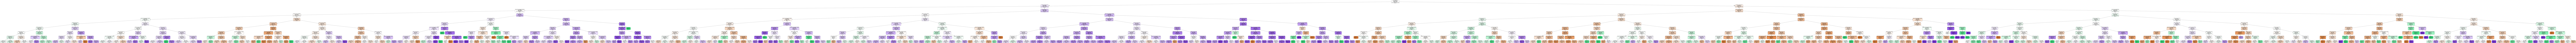

In [ ]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = list(x_train.columns),class_names=['1','2', '3'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('absenteism.png')
Image(graph.create_png())

> Previewing the decision tree . income verified is the highest

### Random forest classifier

In [ ]:
# x=for_model_lab_.drop(['Interest_Rate',],axis=1)
# y=for_model_lab_['Interest_Rate']
x=loan_model.drop(['Interest_Rate',],axis=1)
y=loan_model['Interest_Rate']
x_train,x_test,y_train,y_test=train_test_split(x,y)

In [ ]:
rforest = RandomForestClassifier()
rforest = rforest.fit(x_train, y_train)
y_pred = rforest.predict(x_test) 

print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[ 2411  4546  1499]
 [ 2210 10144  5339]
 [  712  5907  8308]]
              precision    recall  f1-score   support

           1       0.45      0.29      0.35      8456
           2       0.49      0.57      0.53     17693
           3       0.55      0.56      0.55     14927

    accuracy                           0.51     41076
   macro avg       0.50      0.47      0.48     41076
weighted avg       0.50      0.51      0.50     41076



> The random forest did not have the same issue as the decision tree and was able to overcome the class imbalance.so far it has performed better than the default decision tree.

IT performed poorly in the prediction of interest rate 1 since the f1 score is low compared to the others

there was also poor performance in the interest rate 1 where there was a realy low recal since it misclassified most of interest rate 1, however for thos it classified as interest rate 1 most of them were correctly classified.

However since it combines multiple trees it becomes, slow and worse for high dimensional data.


> I decidet to upsamble to see if it would improve the models performance

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

x_train,x_test,y_train,y_test=train_test_split(x,y)

ros = RandomOverSampler(random_state=0)
# ros.fit(x_train, y_train)
# x_over_sampled, y_over_sampled = ros.fit_sample(x, y)

rus = RandomUnderSampler(random_state=0)
# rus.fit(x_train, y_train)
# Creates higher accuracy cause its memorised
# x_under_sampled, y_under_sampled = rus.fit_sample(x, y)
# x_train, y_train = ros.fit_sample(x, y)

x_train_over, y_train_over = ros.fit_sample(x_train, y_train)
x_train_under, y_train_under = rus.fit_sample(x_train, y_train)
# x_test , y_test = ros.fit_sample(x_test,y_test)
# x_test, y_test = ros.fit_resample(x_test,y_test)
# x_train,x_test,y_train,y_test=train_test_split(x_under_sampled, y_under_sampled,test_size=0.2)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [ ]:
rforest = RandomForestClassifier()
rforest = rforest.fit(x_train, y_train)
y_pred = rforest.predict(x_test) 

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.44      0.29      0.35      8405
           2       0.49      0.57      0.53     17779
           3       0.55      0.56      0.55     14892

    accuracy                           0.50     41076
   macro avg       0.49      0.47      0.47     41076
weighted avg       0.50      0.50      0.50     41076



> The performance is similar in accuracy however the difference is visible where there was a improvement in the fi score of interest rate 1 from 0.35 to 0.39 although the f1 score of interest rate 2 droped.

Since there isnt much improvement and since random forest is handling the class imbalance really well we wont be resampling the data.

>Finding the best parameters (criterion, maximum depth and minimum samples split)for the decision tree 

* maximum depth: Is a measure of how deep the decision tree goes, having a reaaly deep tree could lead to overfitting while a shallow tree could lead to underfitting hence its a good idea to get a balance in the tree.
* n_estimators: Is how many trees will be used foor estimating the output of the random forest, Too high a value may not make the tree worce but will increase the amount of time the model runs for since it has to hinge on multiple trees.

In [ ]:
# Avoid running this if you dont need to 8+ hours so yeah try no to
max=np.arange(1,10)
est=np.arange(100,900,100)
grid = GridSearchCV(estimator=RandomForestClassifier(),param_grid={'n_estimators':est,'max_depth':max},cv=5,verbose=1)
grid.fit(x,y)
print('The best parameters ',grid.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 209.0min finished


The best parameters  {'max_depth': 9, 'n_estimators': 300}


In [ ]:
rforest = RandomForestClassifier(max_depth= 9 ,n_estimators=300)
rforest = rforest.fit(x_train, y_train)
y_pred = rforest.predict(x_test) 

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.60      0.11      0.19      8405
           2       0.49      0.69      0.58     17779
           3       0.57      0.56      0.56     14892

    accuracy                           0.53     41076
   macro avg       0.56      0.45      0.44     41076
weighted avg       0.54      0.53      0.49     41076



> The model ended up outperforming the other models, it classification of interest rate 1 improved however the recal and fi score droped, it was really accurate at predicting interest rate 1, the other f1 scores also improved by a large margin

* The tuned model ended up being the best performing random forest classifier